## Importing libs

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [4]:
import warnings
from time import time, strftime

In [5]:
strftime('%X')

'16:37:27'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [6]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

fashion-mnist_test.csv
fashion-mnist_train.csv
README.txt


In [7]:
PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [8]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [9]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [10]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [11]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [12]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [13]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [14]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [15]:
xs_train = xs_train.astype('float32') / 255.0
xs_val = xs_val.astype('float32') / 255.0
xs_test = xs_test.astype('float32') / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [16]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [17]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [18]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [19]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [20]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


## Add helper functions

In [21]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [22]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=64, batch_size=1024, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience))
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

In [23]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [24]:
from sklearn.metrics import confusion_matrix, f1_score

In [25]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [26]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

## 1.1. MLP

In [27]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [28]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [31]:
strftime('%X')

'16:37:35'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 10s 198us/sample - loss: 0.6499 - accuracy: 0.7751 - val_loss: 0.4593 - val_accuracy: 0.8407
Epoch 2/64
48000/48000 [==============================] - 7s 143us/sample - loss: 0.4246 - accuracy: 0.8523 - val_loss: 0.4102 - val_accuracy: 0.8576
Epoch 3/64
48000/48000 [==============================] - 8s 171us/sample - loss: 0.3779 - accuracy: 0.8691 - val_loss: 0.3915 - val_accuracy: 0.8662
Epoch 4/64
48000/48000 [==============================] - 9s 189us/sample - loss: 0.3520 - accuracy: 0.8781 - val_loss: 0.3669 - val_accuracy: 0.8734
Epoch 5/64
48000/48000 [==============================] - 10s 200us/sample - loss: 0.3350 - accuracy: 0.8842 - val_loss: 0.3648 - val_accuracy: 0.8747
Epoch 6/64
48000/48000 [==============================] - 9s 189us/sample - loss: 0.3162 - accuracy: 0.8894 - val_loss: 0.3630 - val_accuracy: 0.8737
Epoch 7/64
48000/48000 [===

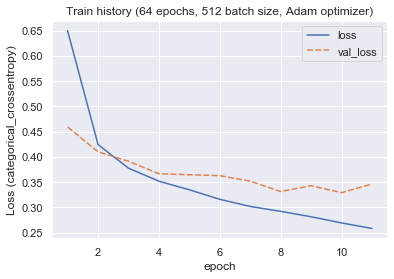

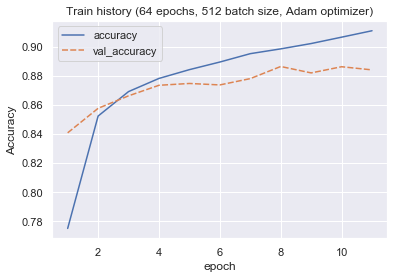

In [32]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val, 
                            n_epochs=64, batch_size=512)

In [33]:
strftime('%X')

'16:39:09'

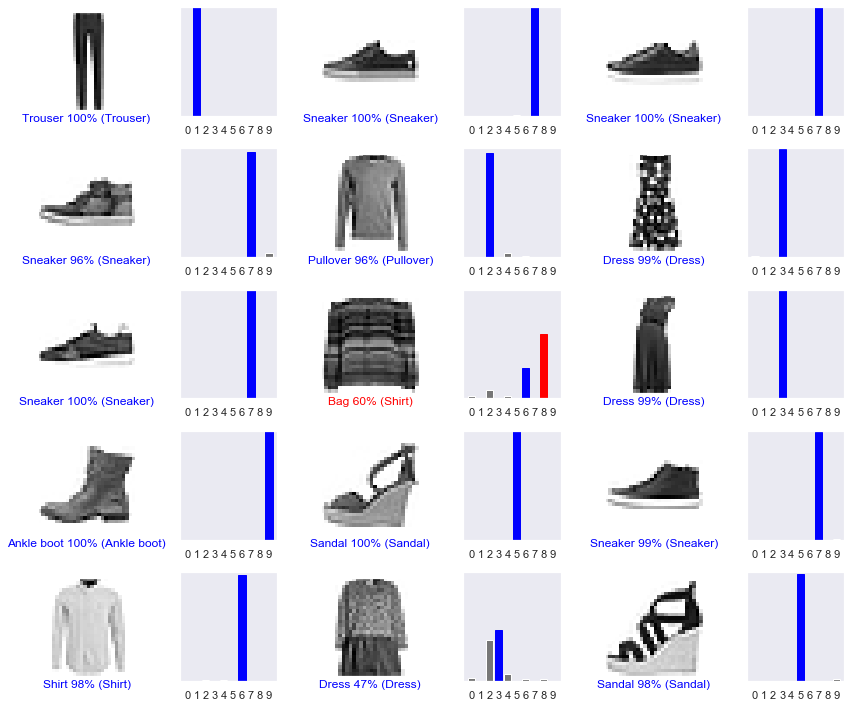

In [34]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

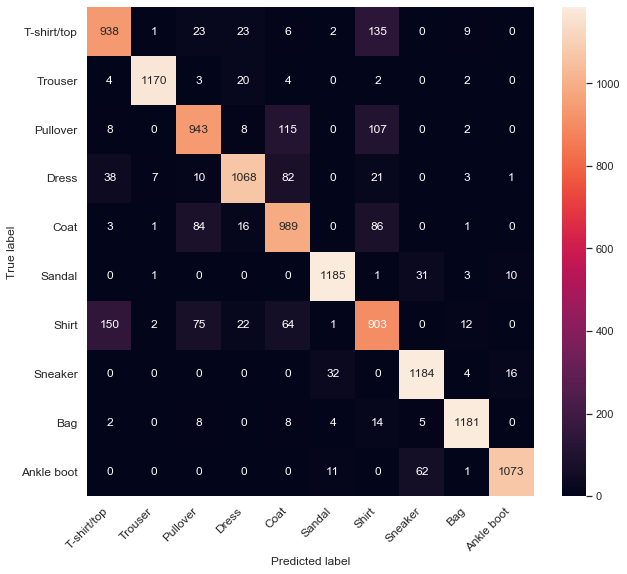

In [35]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

## 1.2. CNN

In [36]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [37]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [38]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [39]:
conv_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [40]:
strftime('%X')

'16:39:13'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 69us/sample - loss: 0.7413 - accuracy: 0.7562 - val_loss: 0.4667 - val_accuracy: 0.8460
Epoch 2/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.4366 - accuracy: 0.8539 - val_loss: 0.4047 - val_accuracy: 0.8637
Epoch 3/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.3839 - accuracy: 0.8738 - val_loss: 0.3840 - val_accuracy: 0.8720
Epoch 4/64
48000/48000 [==============================] - 2s 41us/sample - loss: 0.3565 - accuracy: 0.8821 - val_loss: 0.3460 - val_accuracy: 0.8882
Epoch 5/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.3323 - accuracy: 0.8918 - val_loss: 0.3362 - val_accuracy: 0.8899
Epoch 6/64
48000/48000 [==============================] - 2s 39us/sample - loss: 0.3167 - accuracy: 0.8966 - val_loss: 0.3402 - val_accuracy: 0.8878
Epoch 7/64
48000/48000 [===========

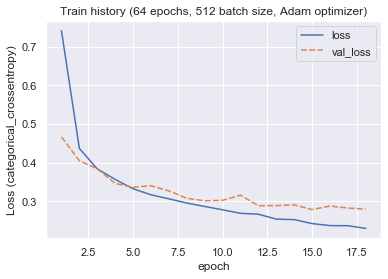

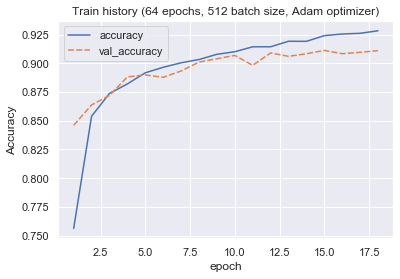

In [41]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val, 
                                      n_epochs=64, batch_size=512)

In [42]:
strftime('%X')

'16:39:49'

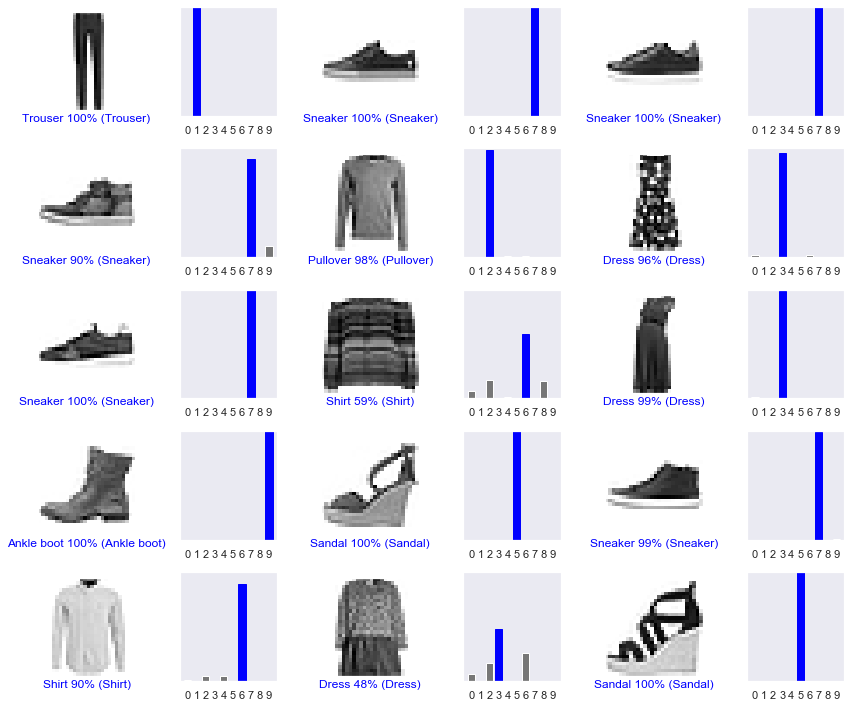

In [43]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

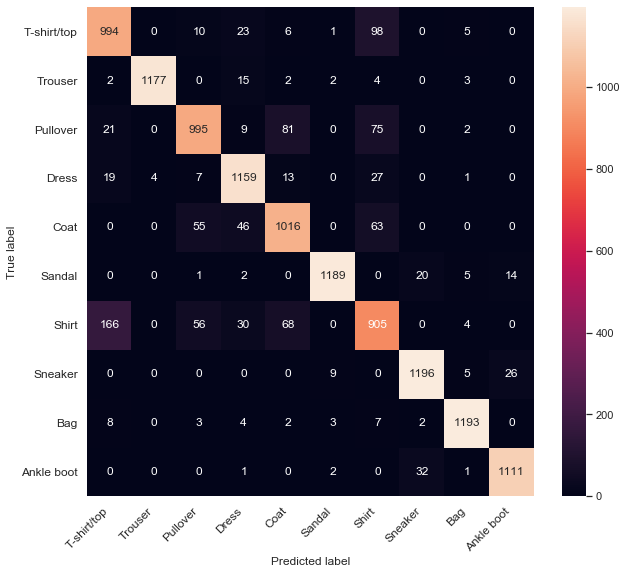

In [44]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 1.3. CNN with batch normalization

In [45]:
from tensorflow.keras.layers import Dropout, BatchNormalization, ReLU

In [46]:
# obs.: padding='valid' by default (i.e. no padding)
conv_v2_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), padding='same'),
    ReLU(),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_v2_baseline")

In [47]:
conv_v2_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [48]:
conv_v2_model.summary()

Model: "CNN_v2_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)    

In [49]:
conv_v2_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [50]:
strftime('%X')

'16:39:53'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 60us/sample - loss: 0.5643 - accuracy: 0.8156 - val_loss: 1.3794 - val_accuracy: 0.6075
Epoch 2/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.3496 - accuracy: 0.8819 - val_loss: 1.2370 - val_accuracy: 0.5389
Epoch 3/64
48000/48000 [==============================] - 2s 48us/sample - loss: 0.3056 - accuracy: 0.8986 - val_loss: 0.8305 - val_accuracy: 0.7139
Epoch 4/64
48000/48000 [==============================] - 2s 51us/sample - loss: 0.2702 - accuracy: 0.9093 - val_loss: 0.5155 - val_accuracy: 0.8282
Epoch 5/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.2509 - accuracy: 0.9185 - val_loss: 0.3548 - val_accuracy: 0.8851
Epoch 6/64
48000/48000 [==============================] - 2s 47us/sample - loss: 0.2283 - accuracy: 0.9254 - val_loss: 0.2973 - val_accuracy: 0.9011
Epoch 7/64
48000/48000 [===========

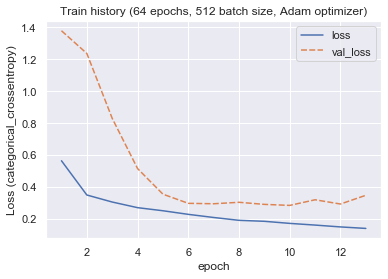

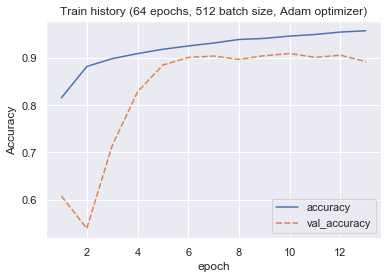

In [51]:
conv_v2_history, best_conv_v2_model = train(conv_v2_model, X_train, Y_train, X_val, Y_val, 
                                            n_epochs=64, batch_size=512)

In [52]:
strftime('%X')

'16:40:25'

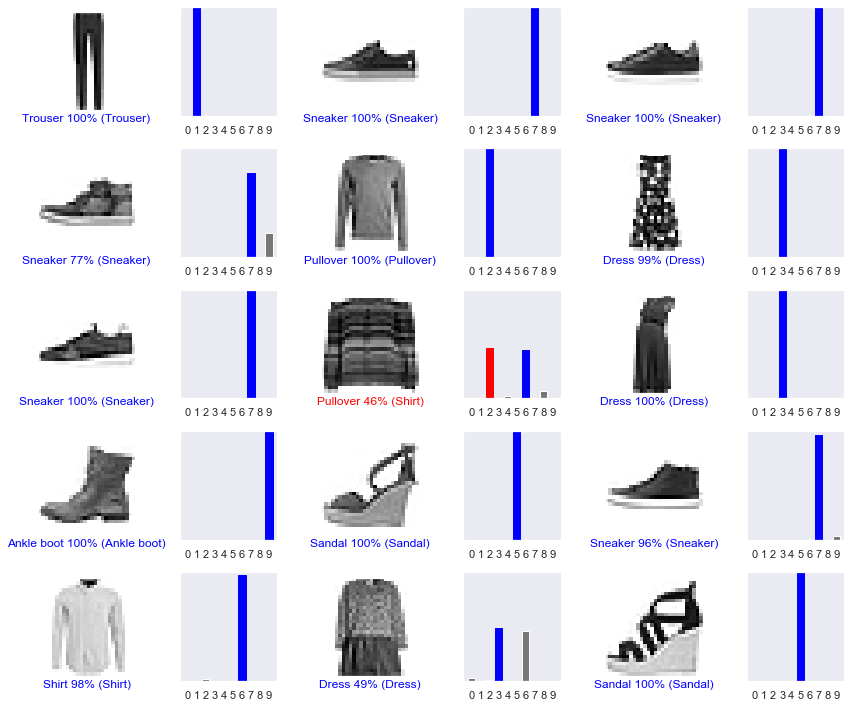

In [53]:
Y_val_conv_v2_pred = best_conv_v2_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_v2_pred)

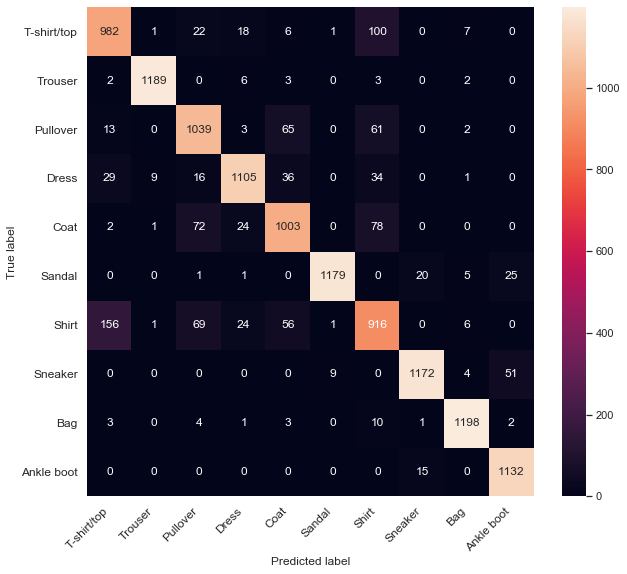

In [54]:
print_cm(ys_val, np.argmax(Y_val_conv_v2_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [55]:
from sklearn.decomposition import PCA

In [56]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [57]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [58]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [59]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

## 2.1. 99% explained variance

In [60]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491833686829 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 7s 145us/sample - loss: 0.7655 - accuracy: 0.7520 - val_loss: 0.4464 - val_accuracy: 0.8528
Epoch 2/64
48000/48000 [==============================] - 7s 151us/sample - loss: 0.3922 - accuracy: 0.8683 - val_loss: 0.3903 - val_accuracy: 0.8667
Epoch 3/64
48000/48000 [==============================] - 7s 156us/sample - loss: 0.3346 - accuracy: 0.8886 - val_loss: 0.3680 - val_accuracy: 0.8745
Epoch 4/64
48000/48000 [==============================] - 8s 172us/sample - loss: 0.2991 - accuracy: 0.8993 - val_loss: 0.3555 - val_accuracy: 0.8783
Epoch 5/64
48000/48000 [==============================] - 9s 179us/sample - loss: 0.2708 - accuracy: 0.9103 - val_loss: 0.3474 - val_accuracy: 0.8829
Epoch 6/64
48000/48000 [==============================] - 8s 169us/sample - loss: 0.2469 - accuracy: 0.9207 - val_loss: 0.3485 - val_accuracy: 0.8808
Epoch 7/64
48000/48000 [=====

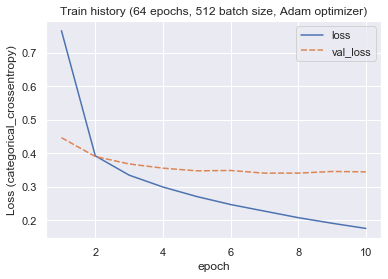

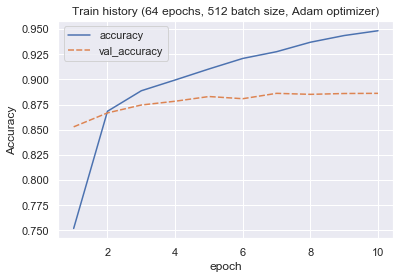

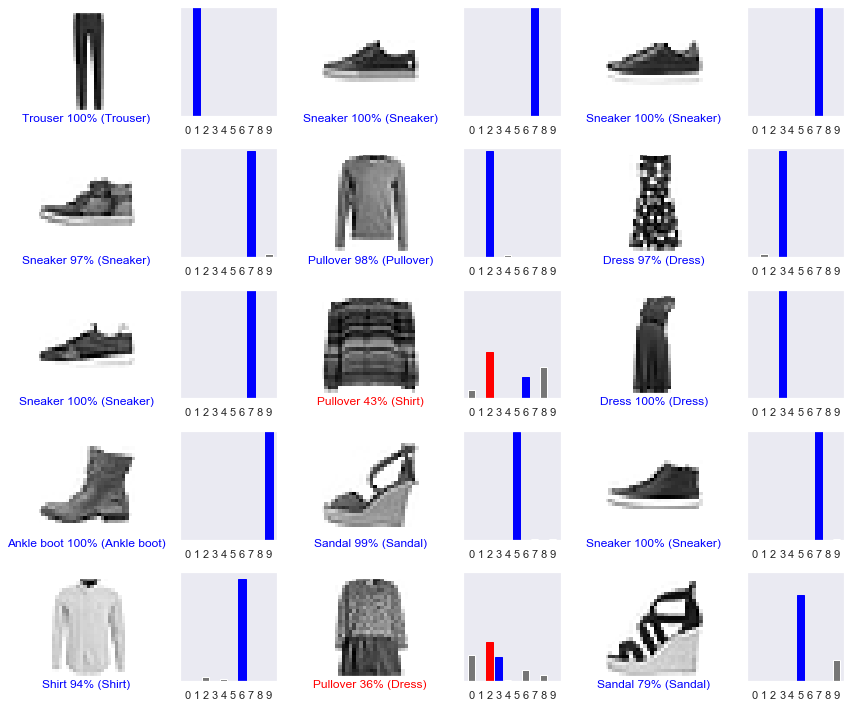

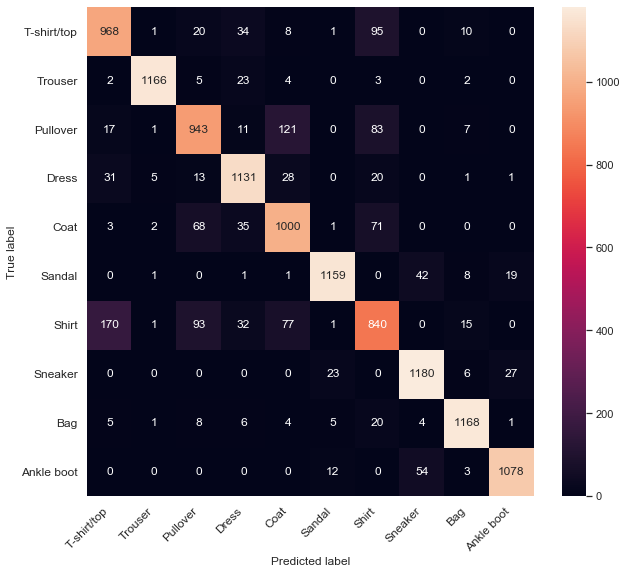

In [61]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

## 2.2. 95% explained variance

In [62]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 8s 160us/sample - loss: 0.8259 - accuracy: 0.7350 - val_loss: 0.4706 - val_accuracy: 0.8436
Epoch 2/64
48000/48000 [==============================] - 8s 166us/sample - loss: 0.4237 - accuracy: 0.8585 - val_loss: 0.4041 - val_accuracy: 0.8630
Epoch 3/64
48000/48000 [==============================] - 6s 135us/sample - loss: 0.3677 - accuracy: 0.8760 - val_loss: 0.3767 - val_accuracy: 0.8732
Epoch 4/64
48000/48000 [==============================] - 7s 147us/sample - loss: 0.3360 - accuracy: 0.8874 - val_loss: 0.3614 - val_accuracy: 0.8768
Epoch 5/64
48000/48000 [==============================] - 7s 145us/sample - loss: 0.3123 - accuracy: 0.8963 - val_loss: 0.3519 - val_accuracy: 0.8804
Epoch 6/64
48000/48000 [==============================] - 8s 158us/sample - loss: 0.2939 - accuracy: 0.9026 - val_loss: 0.3450 - val_accuracy: 0.8822
Epoch 7/64
48000/48000 [=====

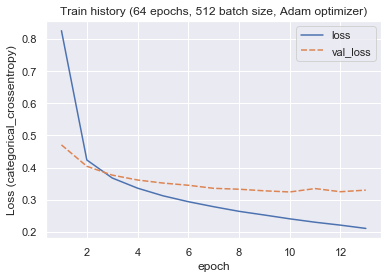

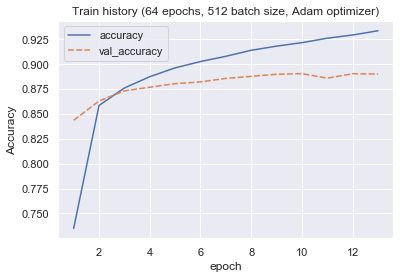

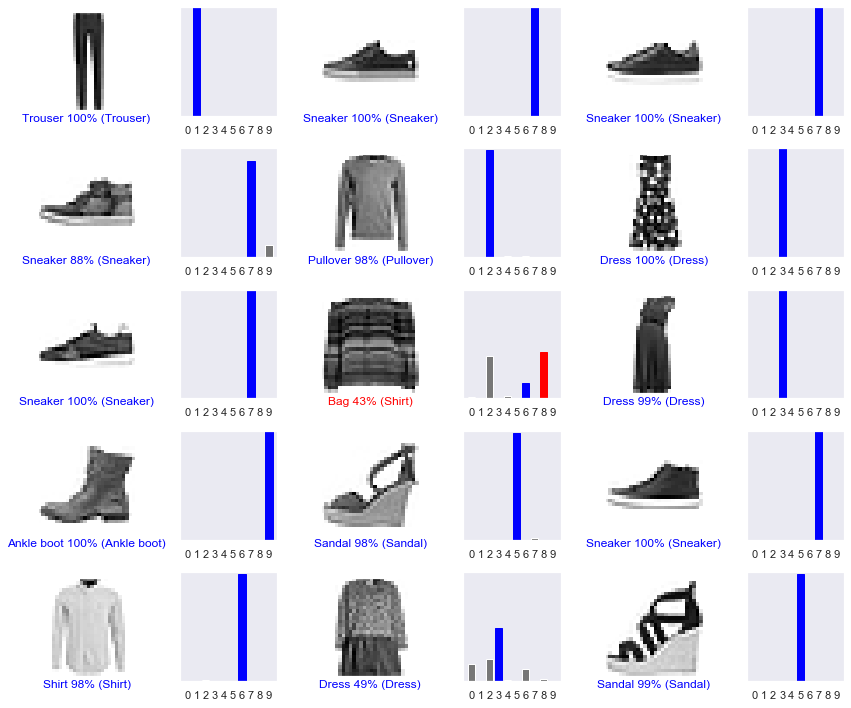

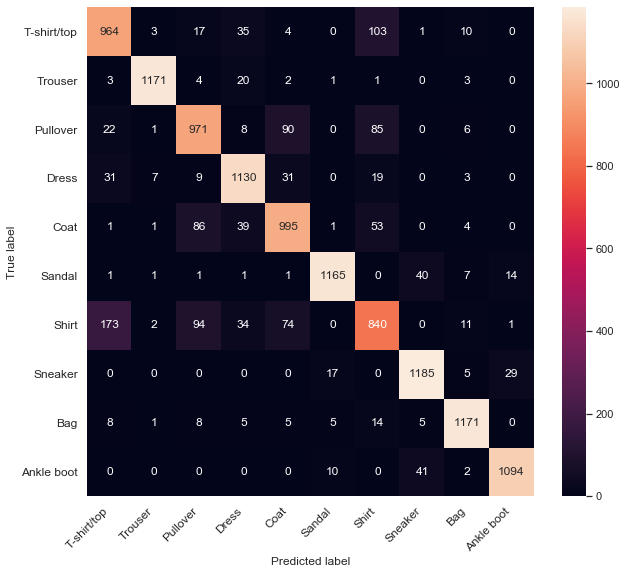

In [63]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

## 2.3. 90% explained variance

In [64]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006991386413574 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 121us/sample - loss: 0.8005 - accuracy: 0.7365 - val_loss: 0.4830 - val_accuracy: 0.8361
Epoch 2/64
48000/48000 [==============================] - 7s 141us/sample - loss: 0.4356 - accuracy: 0.8520 - val_loss: 0.4219 - val_accuracy: 0.8570
Epoch 3/64
48000/48000 [==============================] - 7s 143us/sample - loss: 0.3899 - accuracy: 0.8676 - val_loss: 0.3938 - val_accuracy: 0.8636
Epoch 4/64
48000/48000 [==============================] - 7s 137us/sample - loss: 0.3624 - accuracy: 0.8761 - val_loss: 0.3772 - val_accuracy: 0.8727
Epoch 5/64
48000/48000 [==============================] - 5s 104us/sample - loss: 0.3431 - accuracy: 0.8832 - val_loss: 0.3667 - val_accuracy: 0.8721
Epoch 6/64
48000/48000 [==============================] - 6s 120us/sample - loss: 0.3266 - accuracy: 0.8897 - val_loss: 0.3598 - val_accuracy: 0.8749
Epoch 7/64
48000/48000 [=====

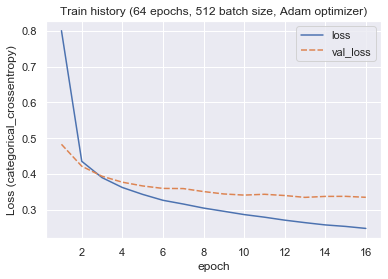

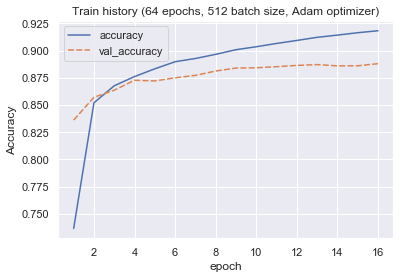

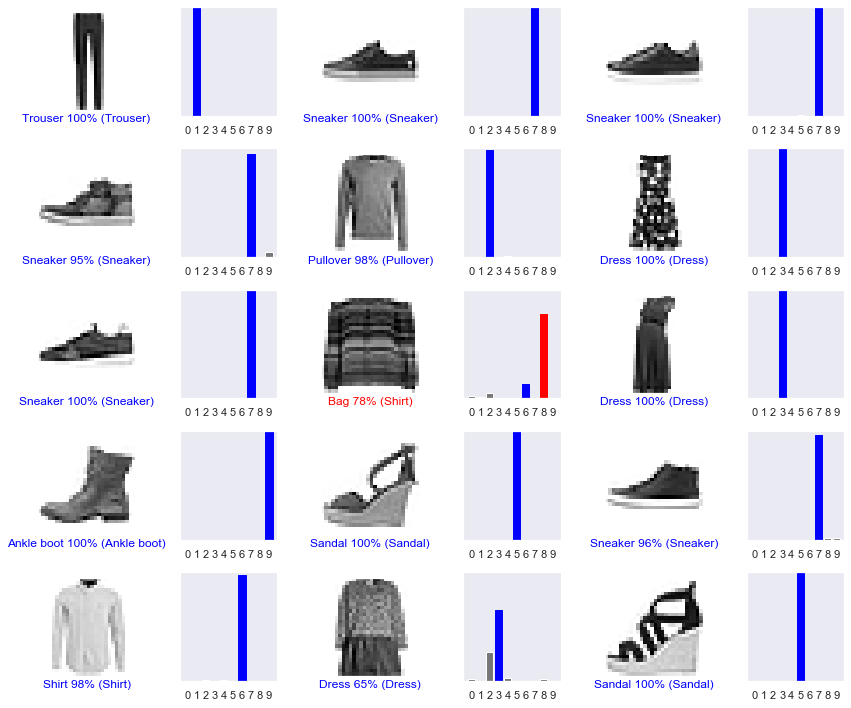

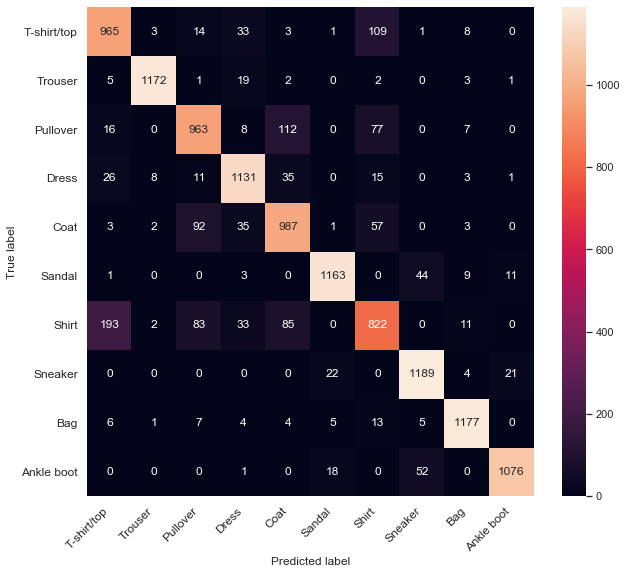

In [65]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

## 2.4. F1-scores

In [66]:
from sklearn.metrics import precision_recall_fscore_support

In [67]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [68]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8206  |  0.8250  |  0.8228
Class 1 (Trouser):       0.9898  |  0.9710  |  0.9803
Class 2 (Pullover):      0.8229  |  0.7971  |  0.8098
Class 3 (Dress):         0.9231  |  0.8683  |  0.8948
Class 4 (Coat):          0.7800  |  0.8381  |  0.8080
Class 5 (Sandal):        0.9595  |  0.9626  |  0.9611
Class 6 (Shirt):         0.7116  |  0.7347  |  0.7230
Class 7 (Sneaker):       0.9236  |  0.9579  |  0.9404
Class 8 (Bag):           0.9696  |  0.9664  |  0.9680
Class 9 (Ankle boot):    0.9755  |  0.9355  |  0.9551

Combined F1 score:  0.8778
Combined Precision: 0.8775
Combined Recall:    0.8781


In [69]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8215  |  0.8742  |  0.8470
Class 1 (Trouser):       0.9966  |  0.9768  |  0.9866
Class 2 (Pullover):      0.8829  |  0.8411  |  0.8615
Class 3 (Dress):         0.8991  |  0.9423  |  0.9202
Class 4 (Coat):          0.8552  |  0.8610  |  0.8581
Class 5 (Sandal):        0.9859  |  0.9659  |  0.9758
Class 6 (Shirt):         0.7676  |  0.7364  |  0.7517
Class 7 (Sneaker):       0.9568  |  0.9676  |  0.9622
Class 8 (Bag):           0.9787  |  0.9763  |  0.9775
Class 9 (Ankle boot):    0.9652  |  0.9686  |  0.9669

Combined F1 score:  0.9043
Combined Precision: 0.9046
Combined Recall:    0.9039


In [70]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8094  |  0.8514  |  0.8298
Class 1 (Trouser):       0.9898  |  0.9676  |  0.9786
Class 2 (Pullover):      0.8200  |  0.7971  |  0.8084
Class 3 (Dress):         0.8885  |  0.9195  |  0.9037
Class 4 (Coat):          0.8045  |  0.8475  |  0.8254
Class 5 (Sandal):        0.9642  |  0.9415  |  0.9527
Class 6 (Shirt):         0.7420  |  0.6835  |  0.7116
Class 7 (Sneaker):       0.9219  |  0.9547  |  0.9380
Class 8 (Bag):           0.9574  |  0.9558  |  0.9566
Class 9 (Ankle boot):    0.9574  |  0.9398  |  0.9485

Combined F1 score:  0.8770
Combined Precision: 0.8778
Combined Recall:    0.8762


In [71]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8013  |  0.8478  |  0.8239
Class 1 (Trouser):       0.9865  |  0.9718  |  0.9791
Class 2 (Pullover):      0.8160  |  0.8208  |  0.8184
Class 3 (Dress):         0.8884  |  0.9187  |  0.9033
Class 4 (Coat):          0.8278  |  0.8432  |  0.8354
Class 5 (Sandal):        0.9716  |  0.9464  |  0.9588
Class 6 (Shirt):         0.7534  |  0.6835  |  0.7167
Class 7 (Sneaker):       0.9316  |  0.9587  |  0.9450
Class 8 (Bag):           0.9583  |  0.9583  |  0.9583
Class 9 (Ankle boot):    0.9613  |  0.9538  |  0.9575

Combined F1 score:  0.8814
Combined Precision: 0.8823
Combined Recall:    0.8806


In [72]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7942  |  0.8487  |  0.8206
Class 1 (Trouser):       0.9865  |  0.9726  |  0.9795
Class 2 (Pullover):      0.8224  |  0.8140  |  0.8182
Class 3 (Dress):         0.8927  |  0.9195  |  0.9059
Class 4 (Coat):          0.8037  |  0.8364  |  0.8198
Class 5 (Sandal):        0.9612  |  0.9448  |  0.9529
Class 6 (Shirt):         0.7507  |  0.6688  |  0.7074
Class 7 (Sneaker):       0.9210  |  0.9620  |  0.9410
Class 8 (Bag):           0.9608  |  0.9632  |  0.9620
Class 9 (Ankle boot):    0.9694  |  0.9381  |  0.9535

Combined F1 score:  0.8772
Combined Precision: 0.8784
Combined Recall:    0.8760


## 2.4. <90% explained variance

**80% explained variance**

In [73]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008706569671631 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 5s 105us/sample - loss: 0.8815 - accuracy: 0.7040 - val_loss: 0.5504 - val_accuracy: 0.8076
Epoch 2/64
48000/48000 [==============================] - 5s 100us/sample - loss: 0.5052 - accuracy: 0.8252 - val_loss: 0.4820 - val_accuracy: 0.8328
Epoch 3/64
48000/48000 [==============================] - 6s 124us/sample - loss: 0.4565 - accuracy: 0.8420 - val_loss: 0.4553 - val_accuracy: 0.8418
Epoch 4/64
48000/48000 [==============================] - 5s 104us/sample - loss: 0.4305 - accuracy: 0.8510 - val_loss: 0.4372 - val_accuracy: 0.8494
Epoch 5/64
48000/48000 [==============================] - 5s 107us/sample - loss: 0.4141 - accuracy: 0.8571 - val_loss: 0.4240 - val_accuracy: 0.8528
Epoch 6/64
48000/48000 [==============================] - 5s 112us/sample - loss: 0.4012 - accuracy: 0.8625 - val_loss: 0.4157 - val_accuracy: 0.8554
Epoch 7/64
48000/48000 [=====

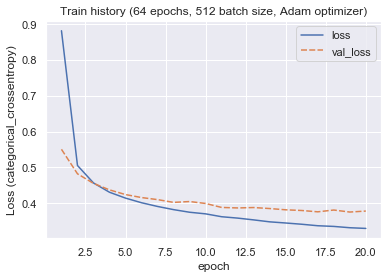

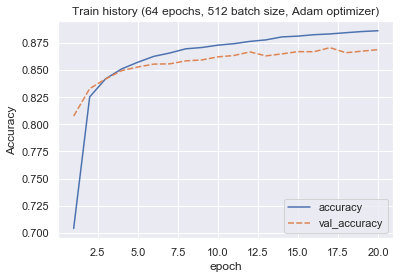

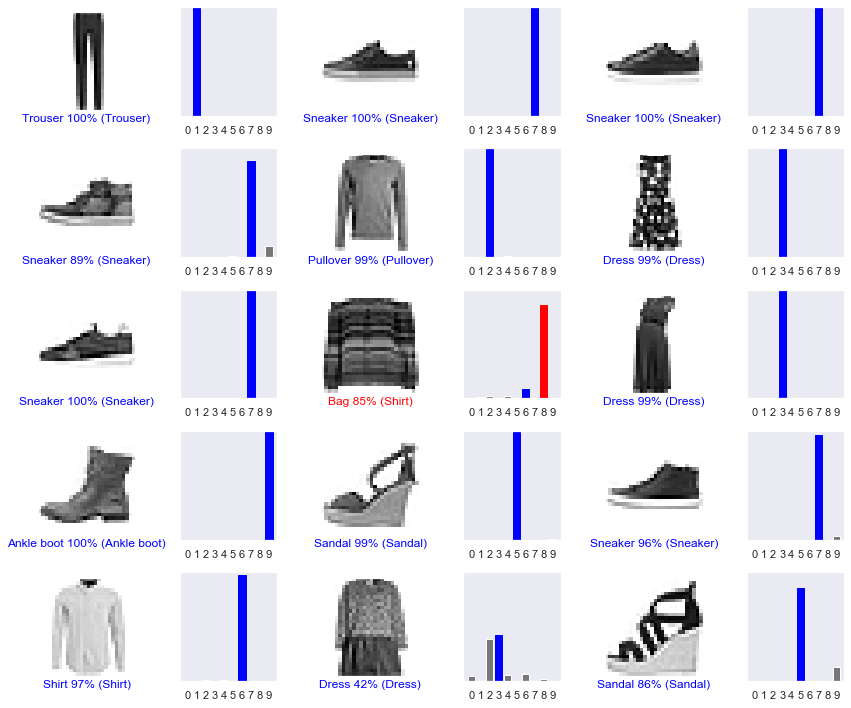

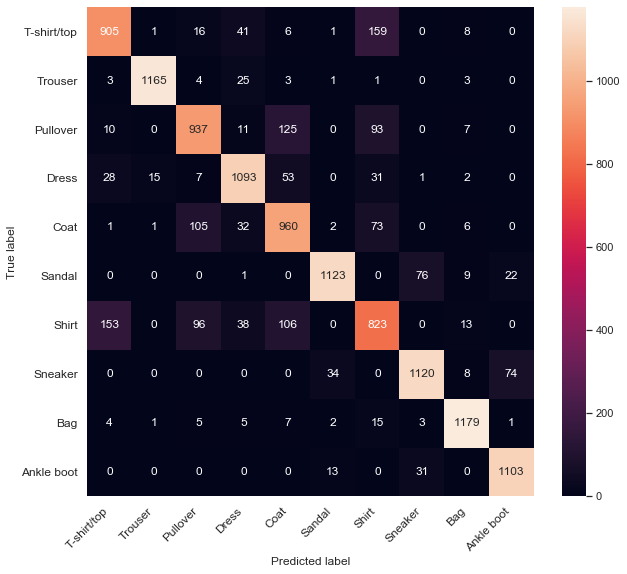

In [74]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [75]:
# 80% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8197  |  0.7960  |  0.8077
Class 1 (Trouser):       0.9848  |  0.9668  |  0.9757
Class 2 (Pullover):      0.8009  |  0.7921  |  0.7964
Class 3 (Dress):         0.8772  |  0.8886  |  0.8829
Class 4 (Coat):          0.7619  |  0.8136  |  0.7869
Class 5 (Sandal):        0.9549  |  0.9123  |  0.9331
Class 6 (Shirt):         0.6887  |  0.6697  |  0.6790
Class 7 (Sneaker):       0.9098  |  0.9061  |  0.9080
Class 8 (Bag):           0.9547  |  0.9648  |  0.9597
Class 9 (Ankle boot):    0.9192  |  0.9616  |  0.9399

Combined F1 score:  0.8566
Combined Precision: 0.8569
Combined Recall:    0.8564


**60% explained variance**

In [76]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156877279281616 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 115us/sample - loss: 1.1128 - accuracy: 0.6250 - val_loss: 0.7909 - val_accuracy: 0.7038
Epoch 2/64
48000/48000 [==============================] - 6s 129us/sample - loss: 0.7601 - accuracy: 0.7153 - val_loss: 0.7381 - val_accuracy: 0.7197
Epoch 3/64
48000/48000 [==============================] - 5s 113us/sample - loss: 0.7282 - accuracy: 0.7238 - val_loss: 0.7204 - val_accuracy: 0.7232
Epoch 4/64
48000/48000 [==============================] - 5s 113us/sample - loss: 0.7122 - accuracy: 0.7288 - val_loss: 0.7131 - val_accuracy: 0.7231
Epoch 5/64
48000/48000 [==============================] - 5s 103us/sample - loss: 0.7007 - accuracy: 0.7331 - val_loss: 0.7022 - val_accuracy: 0.7269
Epoch 6/64
48000/48000 [==============================] - 5s 110us/sample - loss: 0.6930 - accuracy: 0.7354 - val_loss: 0.6984 - val_accuracy: 0.7368
Epoch 7/64
48000/48000 [=====

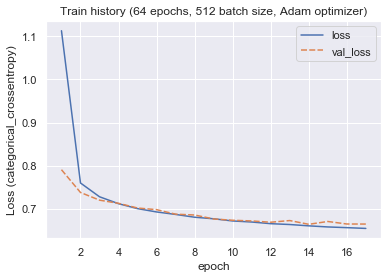

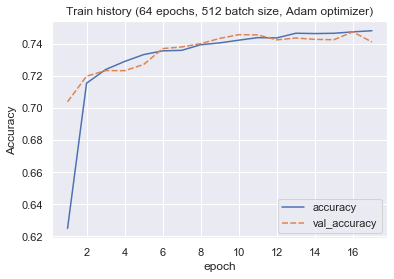

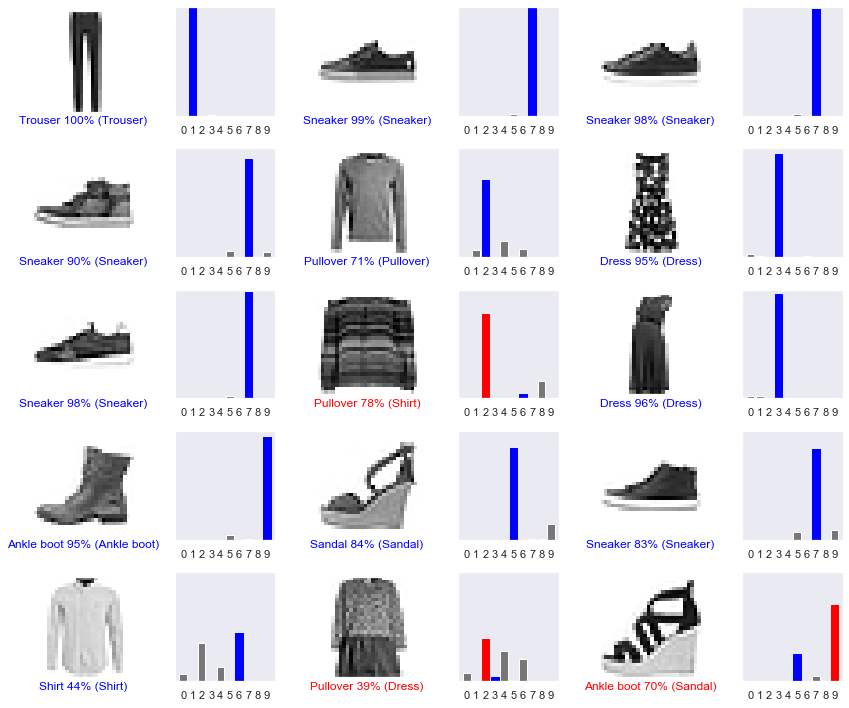

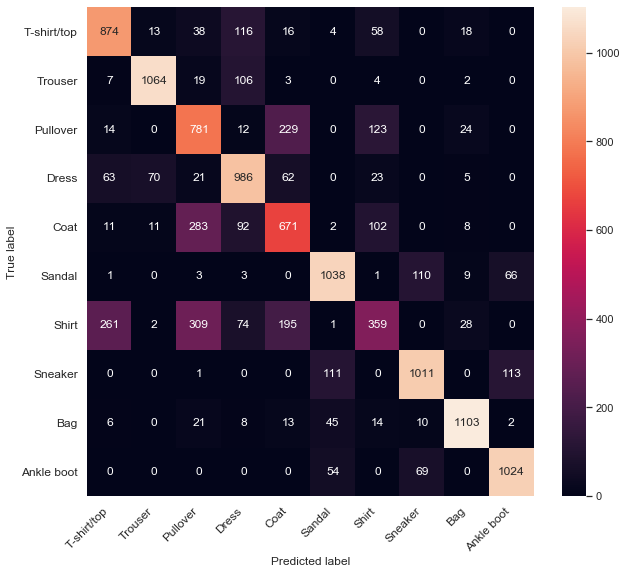

In [77]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [78]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7065  |  0.7687  |  0.7363
Class 1 (Trouser):       0.9172  |  0.8830  |  0.8998
Class 2 (Pullover):      0.5291  |  0.6602  |  0.5874
Class 3 (Dress):         0.7058  |  0.8016  |  0.7507
Class 4 (Coat):          0.5643  |  0.5686  |  0.5665
Class 5 (Sandal):        0.8271  |  0.8432  |  0.8351
Class 6 (Shirt):         0.5249  |  0.2921  |  0.3753
Class 7 (Sneaker):       0.8425  |  0.8180  |  0.8300
Class 8 (Bag):           0.9215  |  0.9026  |  0.9119
Class 9 (Ankle boot):    0.8498  |  0.8928  |  0.8707

Combined F1 score:  0.6858
Combined Precision: 0.7068
Combined Recall:    0.6660


## 2.5. Plot the first 3 principal components

In [79]:
pca_3pc = PCA(n_components=3)

In [80]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [81]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


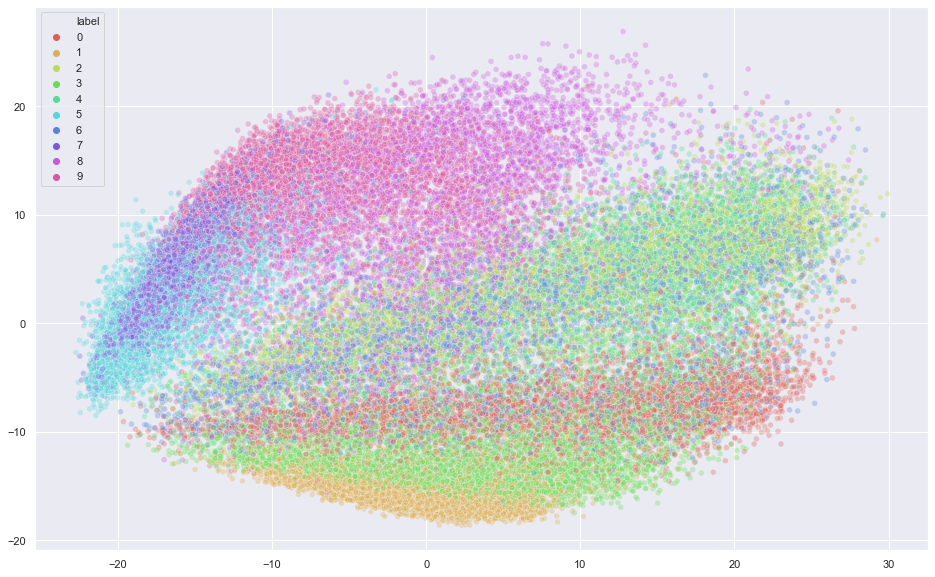

In [82]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [83]:
from mpl_toolkits.mplot3d import Axes3D

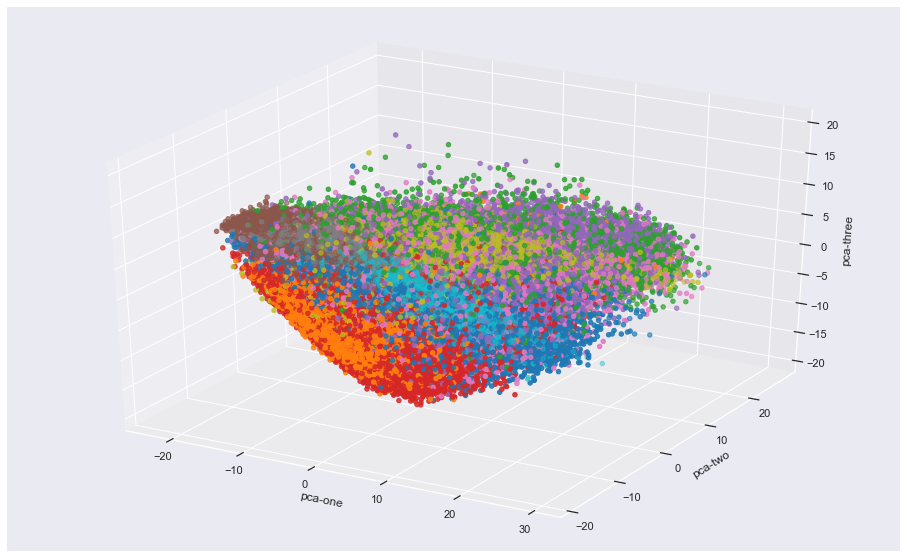

In [84]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [85]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

## 3.1. Latent vector size of 84

## 3.2. Latent vector size of 24

In [86]:
latent_dim = 24

In [87]:
__input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
__encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
__decoded = Dense(784, activation='sigmoid')(__encoded)

In [88]:
autoencoder = Model(__input, __decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_21 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________


In [89]:
encoder = Model(__input, __encoded)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 24)                18840     
Total params: 18,840
Trainable params: 18,840
Non-trainable params: 0
_________________________________________________________________


In [90]:
# create a placeholder for an encoded (24-dimensional) input
encoded_input = Input(shape=(latent_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

In [91]:
decoder = Model(encoded_input, decoder_layer(encoded_input))
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
dense_21 (Dense)             (None, 784)               19600     
Total params: 19,600
Trainable params: 19,600
Non-trainable params: 0
_________________________________________________________________


In [92]:
autoencoder.compile(optimizer='adam', loss='mse')

In [93]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

autoencoder.fit(X_train, X_train,
                validation_data=(X_val, X_val),
                epochs=64,
                batch_size=512,
                shuffle=True,
                callbacks=callbacks)

Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 18us/sample - loss: 0.7876 - val_loss: 0.6297
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.6027 - val_loss: 0.5832
Epoch 3/64
48000/48000 [==============================] - 0s 9us/sample - loss: 0.5742 - val_loss: 0.5674
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5620 - val_loss: 0.5576
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5534 - val_loss: 0.5503
Epoch 6/64
48000/48000 [==============================] - 0s 9us/sample - loss: 0.5469 - val_loss: 0.5441
Epoch 7/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5411 - val_loss: 0.5392
Epoch 8/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5370 - val_loss: 0.5356
Epoch 9/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5337 - val_lo

In [94]:
# encode and decode some digits
encoded_imgs = encoder.predict(X_val)
decoded_imgs = decoder.predict(encoded_imgs)

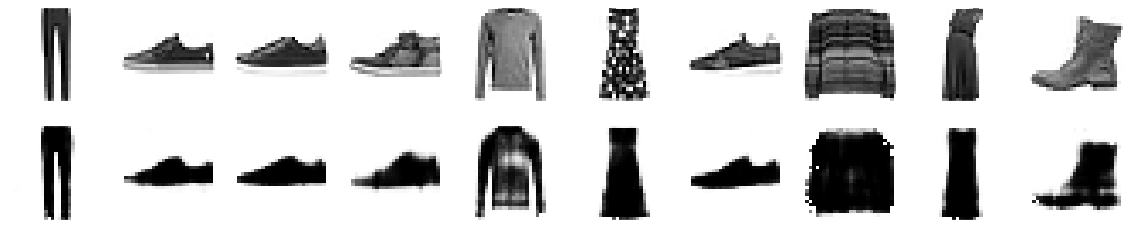

In [95]:
n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [96]:
model_ae_24 = keras.Sequential([
    Input(shape=(encoded_imgs.shape[1], )), # number of components used to keep min_explained_variance
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "AE_24")

In [97]:
model_ae_24.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [98]:
def train_ae_model(model_ae, encoder):
    history_ae, best_model_ae = train(model_ae, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val, 
                                      n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred

In [ ]:
train_ae_model(model_ae_24, encoder)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 130us/sample - loss: 0.9770 - accuracy: 0.6845 - val_loss: 0.5698 - val_accuracy: 0.8029
Epoch 2/64
48000/48000 [==============================] - 5s 97us/sample - loss: 0.5342 - accuracy: 0.8132 - val_loss: 0.4969 - val_accuracy: 0.8252
Epoch 3/64
48000/48000 [==============================] - 6s 134us/sample - loss: 0.4878 - accuracy: 0.8277 - val_loss: 0.4792 - val_accuracy: 0.8286
Epoch 4/64
48000/48000 [==============================] - 6s 118us/sample - loss: 0.4644 - accuracy: 0.8367 - val_loss: 0.4595 - val_accuracy: 0.8346
Epoch 5/64
48000/48000 [==============================] - 5s 113us/sample - loss: 0.4495 - accuracy: 0.8397 - val_loss: 0.4518 - val_accuracy: 0.8388
Epoch 6/64
48000/48000 [==============================] - 5s 110us/sample - loss: 0.4391 - accuracy: 0.8446 - val_loss: 0.4414 - val_accuracy: 0.8447
Epoch 7/64
48000/48000 [======

## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [ ]:
strftime('%X')